<a href="https://colab.research.google.com/github/DHRUVA-N-L-CHOUDHARY/text_alignment_analysis/blob/main/Text_Alignment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
from time import time
from gensim.models import KeyedVectors
import re
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
import string
import re
import seaborn as sns
!pip install fuzzywuzzy

import itertools
import datetime

from keras.utils import pad_sequences
from keras.models import Model
from keras.layers import Input, Embedding, LSTM, Lambda
import keras.backend as K
from keras.optimizers import Adadelta
from keras.callbacks import ModelCheckpoint

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
data = pd.read_csv('https://raw.githubusercontent.com/Kirti1807/Quora-Question-Similarity-Pair/main/data/train.csv')
TRAIN_CSV = data
!gdown "1X82o1u-YEq6pjmxPCUiEjudMOae9k2R-&confirm=t"
EMBEDDING_FILE = './GoogleNews-vectors-negative300.bin.gz'
MODEL_SAVING_DIR = './Models/Kaggle/Quora/'

Downloading...
From: https://drive.google.com/uc?id=1X82o1u-YEq6pjmxPCUiEjudMOae9k2R-&confirm=t
To: /content/GoogleNews-vectors-negative300.bin.gz
100% 1.65G/1.65G [00:28<00:00, 57.6MB/s]


## Basic Data Exploration

In [ ]:
print(data.shape)

(404290, 6)


In [ ]:
data.head(100)

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0
...,...,...,...,...,...,...
95,95,191,192,How does 3D printing work?,How do 3D printing work?,1
96,96,193,194,What was it like to attend Caltech with Jeremy...,Who are some notable folks who attended Caltech?,0
97,97,195,196,Why did harry become a horcrux?,What is a Horcrux?,0
98,98,197,198,What are the best associate product manager (A...,What are the general requirement to become a P...,0


In [ ]:
data.isnull().sum()

id              0
qid1            0
qid2            0
question1       1
question2       2
is_duplicate    0
dtype: int64

In [ ]:
data = data.dropna()

In [ ]:
data.shape

(404287, 6)

In [ ]:
data.isnull().sum()

id              0
qid1            0
qid2            0
question1       0
question2       0
is_duplicate    0
dtype: int64

In [ ]:
data.describe()

,id,qid1,qid2,is_duplicate
count,404287.000000,404287.000000,404287.000000,404287.000000
mean,202144.340337,217243.151093,220955.212082,0.369201
std,116708.673691,157751.614317,159903.168488,0.482589
min,0.000000,1.000000,2.000000,0.000000
25%,101071.500000,74436.500000,74726.500000,0.000000
50%,202145.000000,192181.000000,197053.000000,0.000000
75%,303216.500000,346573.000000,354692.000000,1.000000
max,404289.000000,537932.000000,537933.000000,1.000000


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 404287 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404287 non-null  int64 
 1   qid1          404287 non-null  int64 
 2   qid2          404287 non-null  int64 
 3   question1     404287 non-null  object
 4   question2     404287 non-null  object
 5   is_duplicate  404287 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 21.6+ MB


In [ ]:
print(data.is_duplicate.value_counts())
print(data.is_duplicate.value_counts()/data.is_duplicate.value_counts().sum()*100)

0    255024
1    149263
Name: is_duplicate, dtype: int64
0    63.079941
1    36.920059
Name: is_duplicate, dtype: float64


duplicate question containing data point are 36.92% and non duplicate containing data point are 63.08%

In [ ]:
qids = np.append(data.qid1.values , data.qid2.values)
qids.shape

(808574,)

In [ ]:
print("total no of unique question in data set: ", len(set(qids)))

total no of unique question in data set:  537929


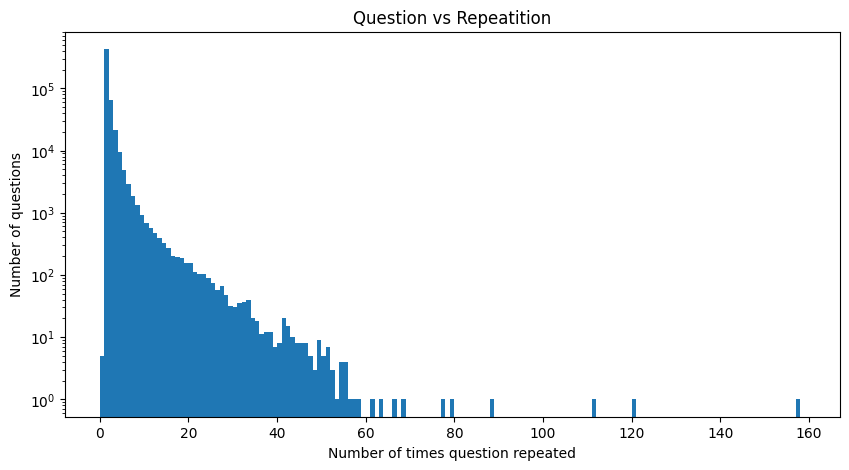

Minimun occurences of any question:  0
Maximum occurences of any question:  157


In [ ]:
occurences = np.bincount(qids)
plt.figure(figsize=(10,5))
plt.hist(occurences, bins=range(0,160))
plt.yscale('log')
plt.xlabel('Number of times question repeated')
plt.ylabel('Number of questions')
plt.title('Question vs Repeatition')
plt.show()
print("Minimun occurences of any question: " , np.min(occurences))
print("Maximum occurences of any question: " , np.max(occurences))

## Data preprocessing

In [ ]:
class tPreprocessing:

    def __init__(self , data):
        self.data = data
        self.my_stopword = list(stopwords.words('english'))
        self.my_lemmatizer = WordNetLemmatizer()

    def text_preprocessing(self , data , column_name):

        data_copy = data.copy()

        data_copy[column_name] = data_copy[column_name].apply(self.lower_text)
        data_copy[column_name] = data_copy[column_name].apply(self.remove_punctuation)
        data_copy[column_name] = data_copy[column_name].apply(self.replace_numeric_to_string)
        data_copy[column_name] = data_copy[column_name].apply(self.remove_urls)
        data_copy[column_name] = data_copy[column_name].apply(self.replace_special_character_to_string_equalent)
        data_copy[column_name] = data_copy[column_name].apply(self.decontrate_words)
        data_copy[column_name] = data_copy[column_name].apply(self.remove_stopwords)
        data_copy[column_name] = data_copy[column_name].apply(self.text_lemmatization)

        return data_copy


    def lower_text(self , text):
        return text.lower().strip()

    def remove_punctuation(self , text):
        text = text.translate(str.maketrans("", "", string.punctuation))
        return text

    def replace_numeric_to_string(self, text):
        text = text.replace(',000,000,000 ', 'b ')
        text = text.replace(',000,000 ', 'm ')
        text = text.replace(',000', 'k ')
        text = re.sub(r'([0-9]+)000000000' , r'\1b', text)
        text = re.sub(r'([0-9]+)000000' , r'\1m', text)
        text = re.sub(r'([0-9]+)000' , r'\1k', text)
        return text

    def remove_urls(self, text):
        text = re.sub(r"http\S+", "", text)
        return text

    def replace_special_character_to_string_equalent(self , text):
        text = text.replace('%' , ' percent')
        text = text.replace('$' , ' dollar')
        text = text.replace('₹' , ' repee')
        text = text.replace('€' , ' euro')
        text = text.replace('@' , ' at')
        return text

    def remove_stopwords(self , text):
        words = text.split()
        new_words = [word for word in words if not word in self.my_stopword]
        text = ' '.join(new_words)
        return text

    def text_lemmatization(self , text):
        text = ' '.join([self.my_lemmatizer.lemmatize(word) for word in text.split()])
        return text

    def decontrate_words(self , text):
        contractions = {
            "ain't": "am not",
            "aren't": "are not",
            "can't": "can not",
            "can't've": "can not have",
            "'cause": "because",
            "could've": "could have",
            "couldn't": "could not",
            "couldn't've": "could not have",
            "didn't": "did not",
            "doesn't": "does not",
            "don't": "do not",
            "hadn't": "had not",
            "hadn't've": "had not have",
            "hasn't": "has not",
            "haven't": "have not",
            "he'd": "he would",
            "he'd've": "he would have",
            "he'll": "he will",
            "he'll've": "he will have",
            "he's": "he is",
            "how'd": "how did",
            "how'd'y": "how do you",
            "how'll": "how will",
            "how's": "how is",
            "i'd": "i would",
            "i'd've": "i would have",
            "i'll": "i will",
            "i'll've": "i will have",
            "i'm": "i am",
            "i've": "i have",
            "isn't": "is not",
            "it'd": "it would",
            "it'd've": "it would have",
            "it'll": "it will",
            "it'll've": "it will have",
            "it's": "it is",
            "let's": "let us",
            "ma'am": "madam",
            "mayn't": "may not",
            "might've": "might have",
            "mightn't": "might not",
            "mightn't've": "might not have",
            "must've": "must have",
            "mustn't": "must not",
            "mustn't've": "must not have",
            "needn't": "need not",
            "needn't've": "need not have",
            "o'clock": "of the clock",
            "oughtn't": "ought not",
            "oughtn't've": "ought not have",
            "shan't": "shall not",
            "sha'n't": "shall not",
            "shan't've": "shall not have",
            "she'd": "she would",
            "she'd've": "she would have",
            "she'll": "she will",
            "she'll've": "she will have",
            "she's": "she is",
            "should've": "should have",
            "shouldn't": "should not",
            "shouldn't've": "should not have",
            "so've": "so have",
            "so's": "so as",
            "that'd": "that would",
            "that'd've": "that would have",
            "that's": "that is",
            "there'd": "there would",
            "there'd've": "there would have",
            "there's": "there is",
            "they'd": "they would",
            "they'd've": "they would have",
            "they'll": "they will",
            "they'll've": "they will have",
            "they're": "they are",
            "they've": "they have",
            "to've": "to have",
            "wasn't": "was not",
            "we'd": "we would",
            "we'd've": "we would have",
            "we'll": "we will",
            "we'll've": "we will have",
            "we're": "we are",
            "we've": "we have",
            "weren't": "were not",
            "what'll": "what will",
            "what'll've": "what will have",
            "what're": "what are",
            "what's": "what is",
            "what've": "what have",
            "when's": "when is",
            "when've": "when have",
            "where'd": "where did",
            "where's": "where is",
            "where've": "where have",
            "who'll": "who will",
            "who'll've": "who will have",
            "who's": "who is",
            "who've": "who have",
            "why's": "why is",
            "why've": "why have",
            "will've": "will have",
            "won't": "will not",
            "won't've": "will not have",
            "would've": "would have",
            "wouldn't": "would not",
            "wouldn't've": "would not have",
            "y'all": "you all",
            "y'all'd": "you all would",
            "y'all'd've": "you all would have",
            "y'all're": "you all are",
            "y'all've": "you all have",
            "you'd": "you would",
            "you'd've": "you would have",
            "you'll": "you will",
            "you'll've": "you will have",
            "you're": "you are",
            "you've": "you have"
           }

        text_decontrate = []

        for word in text.split():
            if word in contractions:
                word = contractions[word]
            text_decontrate.append(word)

        text = ' '.join(text_decontrate)

        return text


In [ ]:
tp = tPreprocessing(data)
data_ = tp.text_preprocessing(data , 'question1')
data__ = tp.text_preprocessing(data_ , 'question2')

train_df = data__

In [ ]:
data__.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,step step guide invest share market india,step step guide invest share market,0
1,1,3,4,story kohinoor kohinoor diamond,would happen indian government stole kohinoor ...,0
2,2,5,6,increase speed internet connection using vpn,internet speed increased hacking dns,0
3,3,7,8,mentally lonely solve,find remainder math2324math divided 2423,0
4,4,9,10,one dissolve water quikly sugar salt methane c...,fish would survive salt water,0


## Features Engineering

In [ ]:
from fuzzywuzzy import fuzz

/usr/local/lib/python3.10/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [ ]:
class FeatureEngineering:

    def __init__(self , data):
        self.data = data


    def feature_extraction(self , data):

        data_copy = data.copy()

        data_copy['length_of_q1'] = data_copy['question1'].apply(lambda text : len(text))

        data_copy['length_of_q2'] = data_copy['question2'].apply(lambda text : len(text))

        data_copy['total_number_of_words_in_q1'] = data_copy['question1'].apply(lambda text : len(nltk.word_tokenize(text)))

        data_copy['total_number_of_words_in_q2'] = data_copy['question2'].apply(lambda text : len(nltk.word_tokenize(text)))

        data_copy['sum_of_total_words_of_q1_and_q2'] = data_copy['total_number_of_words_in_q1'] + data_copy['total_number_of_words_in_q2']

        data_copy['number_of_unique_words_in_q1'] = data_copy['question1'].apply(lambda text : len(set(nltk.word_tokenize(text))))

        data_copy['number_of_unique_words_in_q2'] = data_copy['question2'].apply(lambda text : len(set(nltk.word_tokenize(text))))

        data_copy['sum_of_total_uinque_words_of_q1_and_q2'] = data_copy['number_of_unique_words_in_q1'] + data_copy['number_of_unique_words_in_q2']

        data_copy['ratio_of_total_unique_words_and_total_words'] = data_copy['sum_of_total_uinque_words_of_q1_and_q2']/data_copy['sum_of_total_words_of_q1_and_q2']

        data_copy['number_of_common_words_in_q1_and_q2'] = data_copy.apply(lambda x : len(set(x.question1.split()).intersection(set(x.question2.split()))) , axis=1)

        data_copy['ratio_of_common_words_of_q1q2_and_total_words'] = data_copy['number_of_common_words_in_q1_and_q2']/data_copy['sum_of_total_words_of_q1_and_q2']

        data_copy['ratio_of_common_words_of_q1q2_and_total_unique_words'] = data_copy['number_of_common_words_in_q1_and_q2']/data_copy['sum_of_total_uinque_words_of_q1_and_q2']

        data_copy['ratio_of_common_words_and_length_of_smaller_question'] = data_copy['number_of_common_words_in_q1_and_q2']/np.minimum(data_copy['length_of_q1'] , data_copy['length_of_q2'])

        data_copy['ratio_of_common_words_and_length_of_larger_question'] = data_copy['number_of_common_words_in_q1_and_q2']/np.maximum(data_copy['length_of_q1'] , data_copy['length_of_q2'])

        return data_copy

    def add_fuzzywuzzy_features(self , data):

        data_copy = data.copy()

        data_copy['fuzz_ratio'] = data_copy.apply(lambda x : fuzz.ratio(x.question1 , x.question2) , axis=1)

        data_copy['fuzz_partial_ratio'] = data_copy.apply(lambda x : fuzz.partial_ratio(x.question1 , x.question2) , axis=1)

        data_copy['fuzz_token_sort_ratio'] = data_copy.apply(lambda x : fuzz.token_sort_ratio(x.question1 , x.question2) , axis=1)

        data_copy['fuzz_token_set_ratio'] = data_copy.apply(lambda x : fuzz.token_set_ratio(x.question1 , x.question2) , axis=1)

        return data_copy


In [ ]:
fe = FeatureEngineering(data__)
df = fe.feature_extraction(data__)
df = fe.add_fuzzywuzzy_features(df)

In [ ]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,length_of_q1,length_of_q2,total_number_of_words_in_q1,total_number_of_words_in_q2,...,ratio_of_total_unique_words_and_total_words,number_of_common_words_in_q1_and_q2,ratio_of_common_words_of_q1q2_and_total_words,ratio_of_common_words_of_q1q2_and_total_unique_words,ratio_of_common_words_and_length_of_smaller_question,ratio_of_common_words_and_length_of_larger_question,fuzz_ratio,fuzz_partial_ratio,fuzz_token_sort_ratio,fuzz_token_set_ratio
0,0,1,2,step step guide invest share market india,step step guide invest share market,0,41,35,7,6,...,0.846154,5,0.384615,0.454545,0.142857,0.121951,92,100,92,100
1,1,3,4,story kohinoor kohinoor diamond,would happen indian government stole kohinoor ...,0,31,67,4,9,...,0.846154,2,0.153846,0.181818,0.064516,0.029851,59,94,59,84
2,2,5,6,increase speed internet connection using vpn,internet speed increased hacking dns,0,44,36,6,5,...,1.000000,2,0.181818,0.181818,0.055556,0.045455,55,46,65,65
3,3,7,8,mentally lonely solve,find remainder math2324math divided 2423,0,21,40,3,5,...,1.000000,0,0.000000,0.000000,0.000000,0.000000,23,24,20,20
4,4,9,10,one dissolve water quikly sugar salt methane c...,fish would survive salt water,0,60,29,10,5,...,1.000000,2,0.133333,0.133333,0.068966,0.033333,25,52,40,51


In [ ]:
df.shape

(404287, 24)

In [ ]:
df.columns

Index(['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate',
       'length_of_q1', 'length_of_q2', 'total_number_of_words_in_q1',
       'total_number_of_words_in_q2', 'sum_of_total_words_of_q1_and_q2',
       'number_of_unique_words_in_q1', 'number_of_unique_words_in_q2',
       'sum_of_total_uinque_words_of_q1_and_q2',
       'ratio_of_total_unique_words_and_total_words',
       'number_of_common_words_in_q1_and_q2',
       'ratio_of_common_words_of_q1q2_and_total_words',
       'ratio_of_common_words_of_q1q2_and_total_unique_words',
       'ratio_of_common_words_and_length_of_smaller_question',
       'ratio_of_common_words_and_length_of_larger_question', 'fuzz_ratio',
       'fuzz_partial_ratio', 'fuzz_token_sort_ratio', 'fuzz_token_set_ratio'],
      dtype='object')

## Exploratery Data Analysis

<ipython-input-31-d2d085dc83db>:12: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(x='length_of_q1' , hue='is_duplicate' , data=df , shade=True)


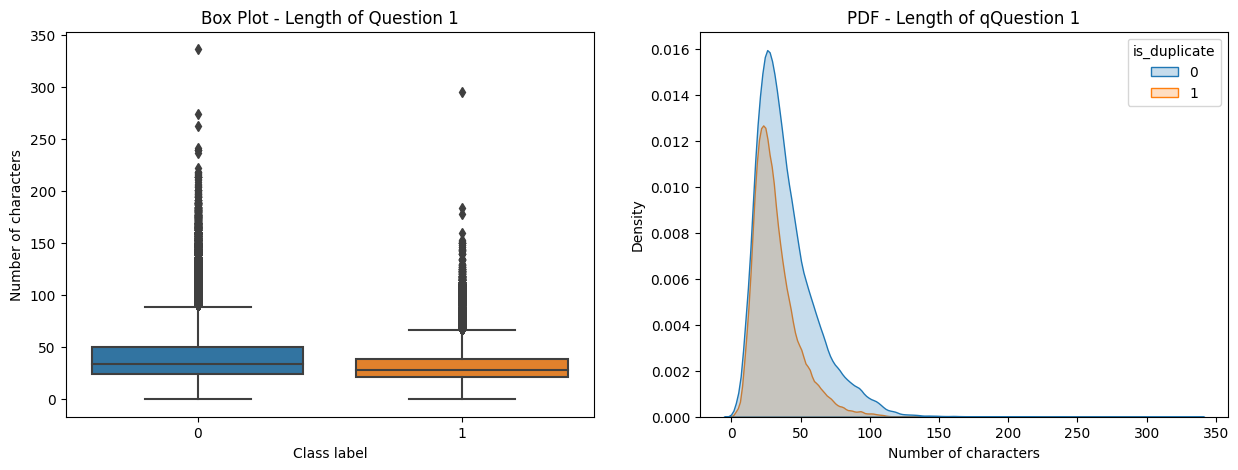

In [ ]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)

sns.boxplot(x='is_duplicate' , y='length_of_q1' , data=df)
plt.title('Box Plot - Length of Question 1')
plt.xlabel('Class label')
plt.ylabel('Number of characters')

plt.subplot(1,2,2)

sns.kdeplot(x='length_of_q1' , hue='is_duplicate' , data=df , shade=True)
plt.title('PDF - Length of qQuestion 1')
plt.xlabel('Number of characters')

plt.show()

<ipython-input-32-32467adb2037>:12: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(x='length_of_q2' , hue='is_duplicate' , data=df , shade=True)


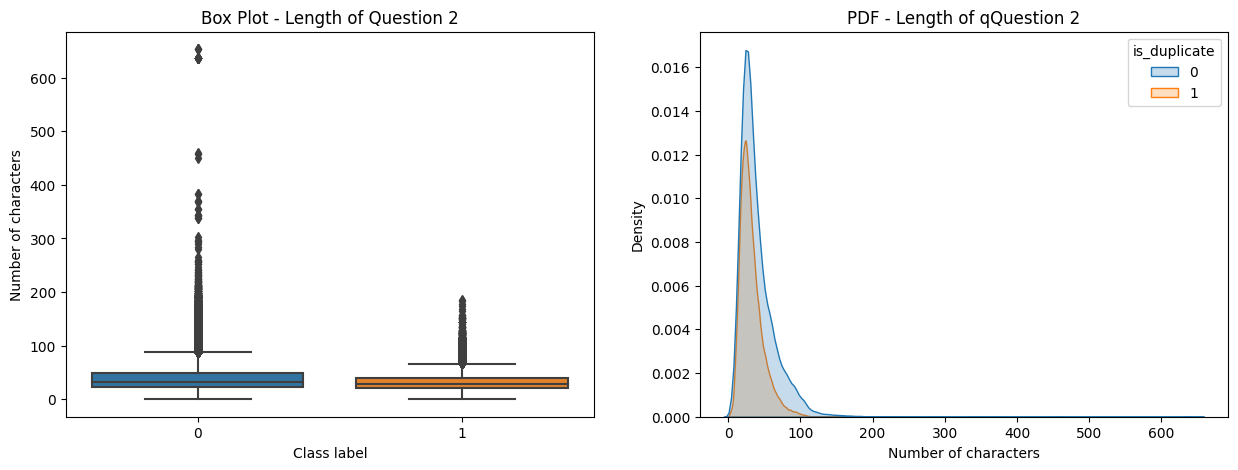

In [ ]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)

sns.boxplot(x='is_duplicate' , y='length_of_q2' , data=df)
plt.title('Box Plot - Length of Question 2')
plt.xlabel('Class label')
plt.ylabel('Number of characters')

plt.subplot(1,2,2)

sns.kdeplot(x='length_of_q2' , hue='is_duplicate' , data=df , shade=True)
plt.title('PDF - Length of qQuestion 2')
plt.xlabel('Number of characters')

plt.show()

<ipython-input-33-37f1834ade47>:12: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=False`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(x='total_number_of_words_in_q1' , hue='is_duplicate' , data=df , shade=False)


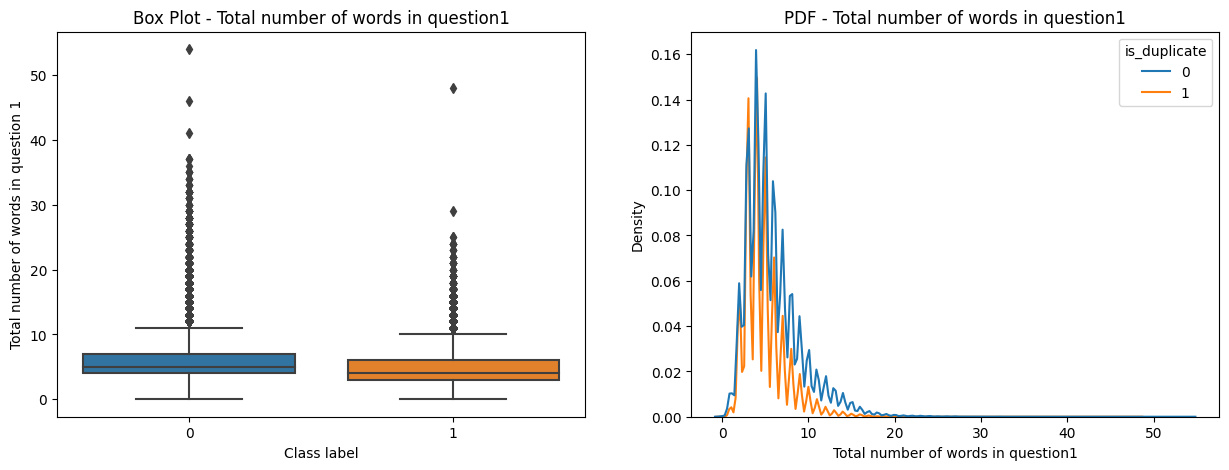

In [ ]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)

sns.boxplot(x='is_duplicate' , y='total_number_of_words_in_q1' , data=df)
plt.title('Box Plot - Total number of words in question1')
plt.xlabel('Class label')
plt.ylabel('Total number of words in question 1')

plt.subplot(1,2,2)

sns.kdeplot(x='total_number_of_words_in_q1' , hue='is_duplicate' , data=df , shade=False)
plt.title('PDF - Total number of words in question1')
plt.xlabel('Total number of words in question1')

plt.show()

<ipython-input-34-9ee5a7fb86b4>:12: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=False`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(x='total_number_of_words_in_q2' , hue='is_duplicate' , data=df , shade=False)


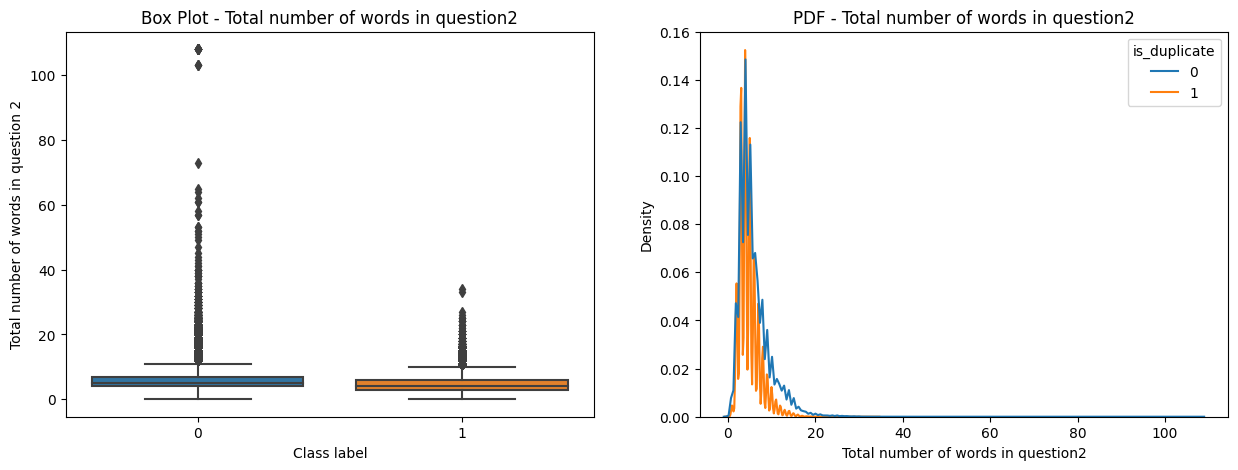

In [ ]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)

sns.boxplot(x='is_duplicate' , y='total_number_of_words_in_q2' , data=df)
plt.title('Box Plot - Total number of words in question2')
plt.xlabel('Class label')
plt.ylabel('Total number of words in question 2')

plt.subplot(1,2,2)

sns.kdeplot(x='total_number_of_words_in_q2' , hue='is_duplicate' , data=df , shade=False)
plt.title('PDF - Total number of words in question2')
plt.xlabel('Total number of words in question2')

plt.show()

<ipython-input-35-dc2c7707ace5>:12: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=False`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(x='sum_of_total_words_of_q1_and_q2' , hue='is_duplicate' , data=df , shade=False)


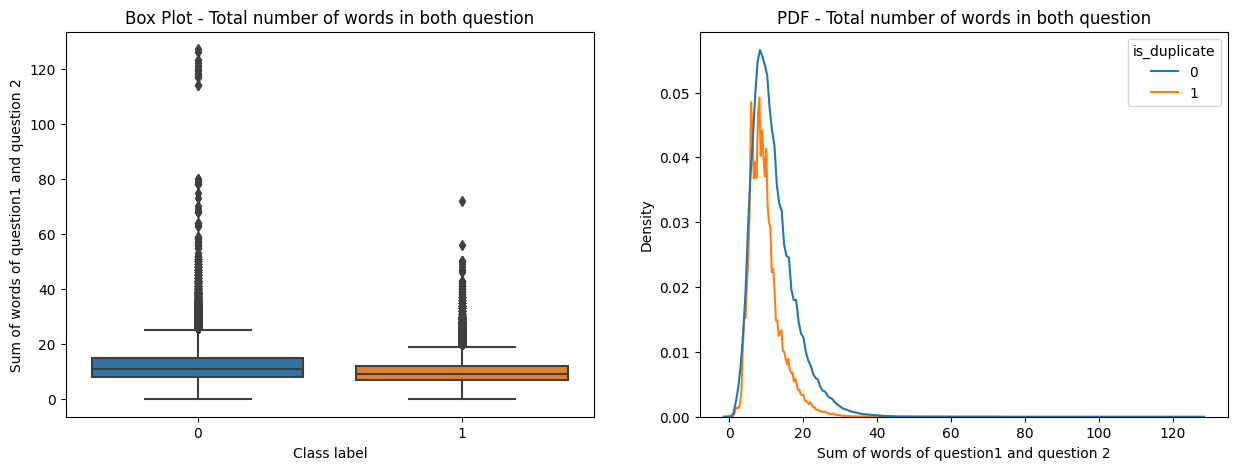

In [ ]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)

sns.boxplot(x='is_duplicate' , y='sum_of_total_words_of_q1_and_q2' , data=df)
plt.title('Box Plot - Total number of words in both question')
plt.xlabel('Class label')
plt.ylabel('Sum of words of question1 and question 2')

plt.subplot(1,2,2)

sns.kdeplot(x='sum_of_total_words_of_q1_and_q2' , hue='is_duplicate' , data=df , shade=False)
plt.title('PDF - Total number of words in both question')
plt.xlabel('Sum of words of question1 and question 2')

plt.show()

<ipython-input-36-ffeb440c473a>:12: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=False`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(x='number_of_unique_words_in_q1' , hue='is_duplicate' , data=df , shade=False)


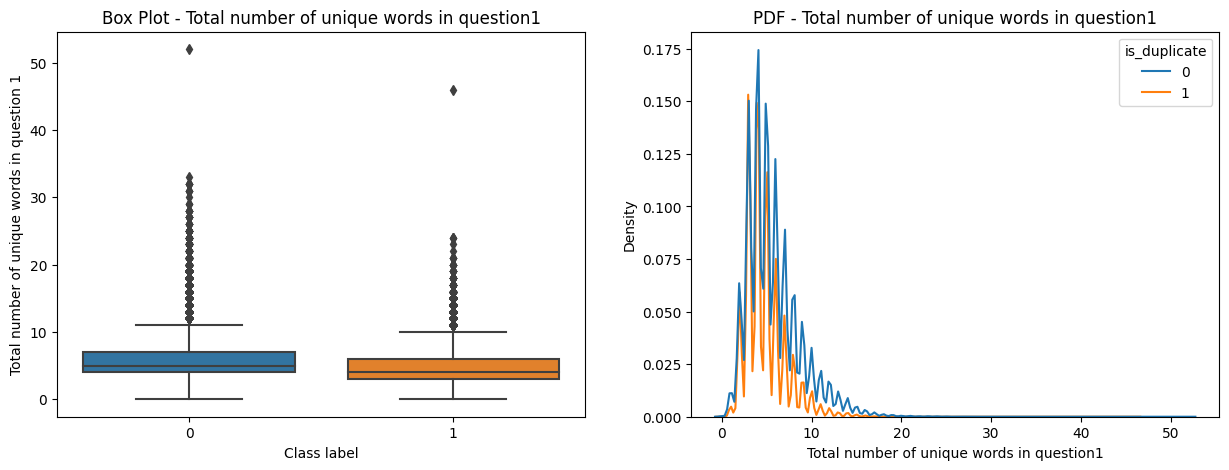

In [ ]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)

sns.boxplot(x='is_duplicate' , y='number_of_unique_words_in_q1' , data=df)
plt.title('Box Plot - Total number of unique words in question1')
plt.xlabel('Class label')
plt.ylabel('Total number of unique words in question 1')

plt.subplot(1,2,2)

sns.kdeplot(x='number_of_unique_words_in_q1' , hue='is_duplicate' , data=df , shade=False)
plt.title('PDF - Total number of unique words in question1')
plt.xlabel('Total number of unique words in question1')

plt.show()

<ipython-input-37-79e6f04e42ed>:12: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=False`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(x='number_of_unique_words_in_q2' , hue='is_duplicate' , data=df , shade=False)


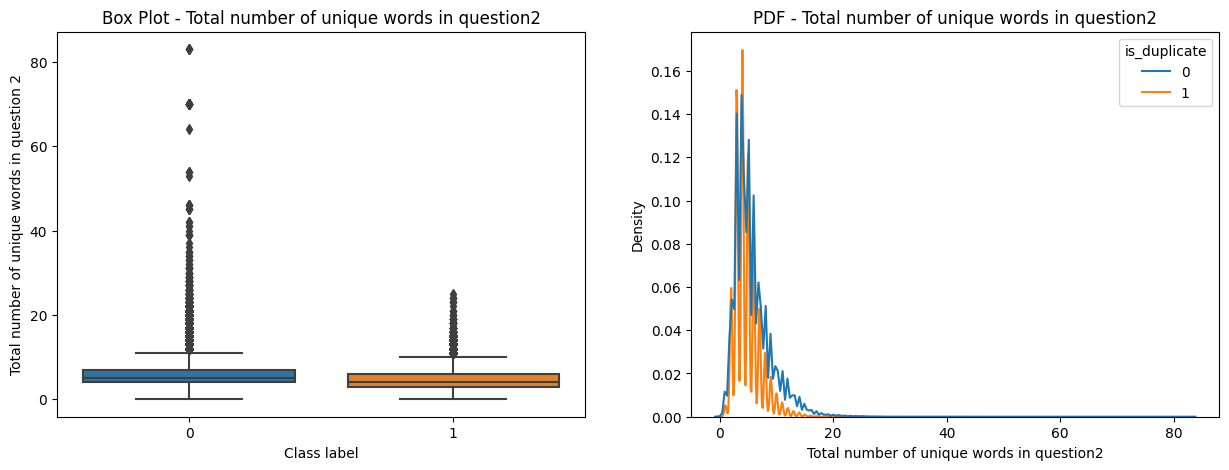

In [ ]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)

sns.boxplot(x='is_duplicate' , y='number_of_unique_words_in_q2' , data=df)
plt.title('Box Plot - Total number of unique words in question2')
plt.xlabel('Class label')
plt.ylabel('Total number of unique words in question 2')

plt.subplot(1,2,2)

sns.kdeplot(x='number_of_unique_words_in_q2' , hue='is_duplicate' , data=df , shade=False)
plt.title('PDF - Total number of unique words in question2')
plt.xlabel('Total number of unique words in question2')

plt.show()

<ipython-input-38-d33656ada2a4>:12: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=False`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(x='sum_of_total_uinque_words_of_q1_and_q2' , hue='is_duplicate' , data=df , shade=False)


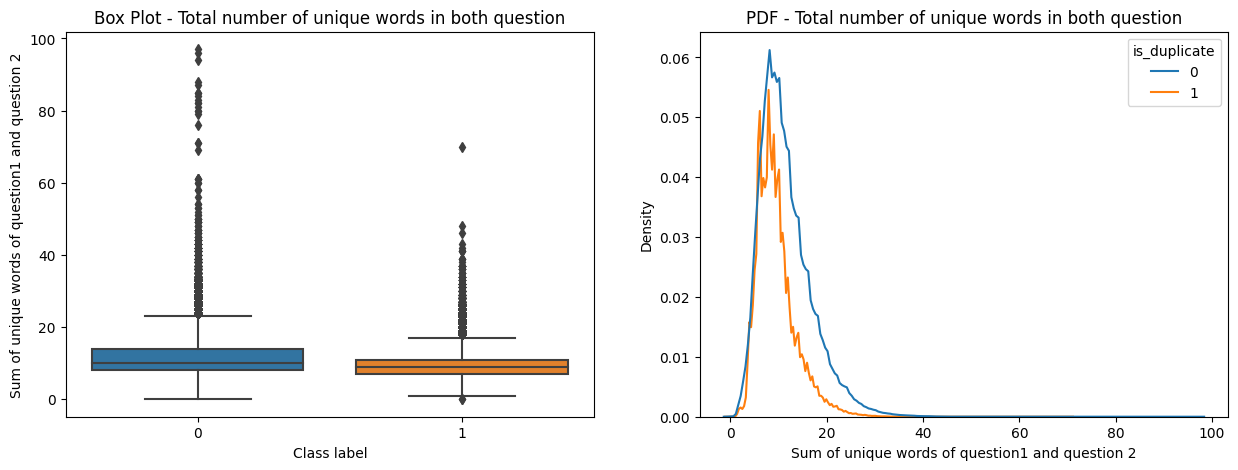

In [ ]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)

sns.boxplot(x='is_duplicate' , y='sum_of_total_uinque_words_of_q1_and_q2' , data=df)
plt.title('Box Plot - Total number of unique words in both question')
plt.xlabel('Class label')
plt.ylabel('Sum of unique words of question1 and question 2')

plt.subplot(1,2,2)

sns.kdeplot(x='sum_of_total_uinque_words_of_q1_and_q2' , hue='is_duplicate' , data=df , shade=False)
plt.title('PDF - Total number of unique words in both question')
plt.xlabel('Sum of unique words of question1 and question 2')

plt.show()

<ipython-input-39-5cfcb45b06ef>:12: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=False`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(x='ratio_of_total_unique_words_and_total_words', hue='is_duplicate' , data=df , shade=False)


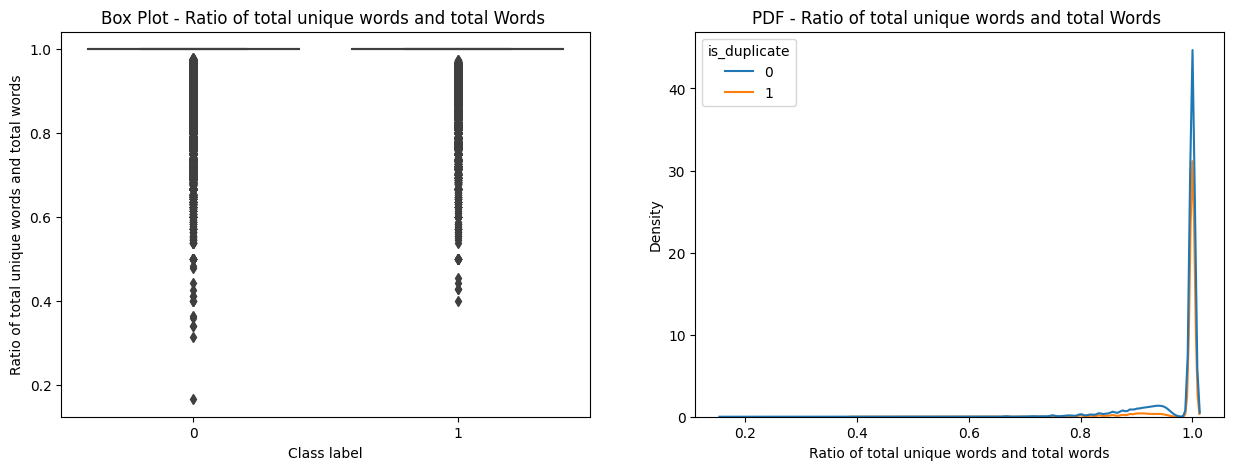

In [ ]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)

sns.boxplot(x='is_duplicate' , y='ratio_of_total_unique_words_and_total_words', data=df)
plt.title('Box Plot - Ratio of total unique words and total Words ')
plt.xlabel('Class label')
plt.ylabel('Ratio of total unique words and total words')

plt.subplot(1,2,2)

sns.kdeplot(x='ratio_of_total_unique_words_and_total_words', hue='is_duplicate' , data=df , shade=False)
plt.title('PDF - Ratio of total unique words and total Words ')
plt.xlabel('Ratio of total unique words and total words')

plt.show()

<ipython-input-40-2c745d575f2a>:12: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=False`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(x='number_of_common_words_in_q1_and_q2', hue='is_duplicate' , data=df , shade=False)


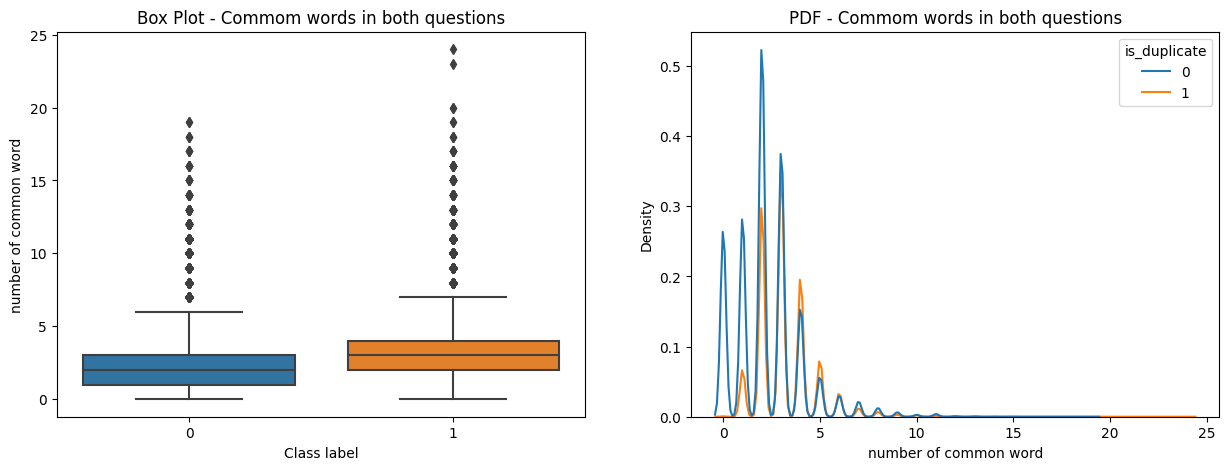

In [ ]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)

sns.boxplot(x='is_duplicate' , y='number_of_common_words_in_q1_and_q2', data=df)
plt.title('Box Plot - Commom words in both questions')
plt.xlabel('Class label')
plt.ylabel('number of common word')

plt.subplot(1,2,2)

sns.kdeplot(x='number_of_common_words_in_q1_and_q2', hue='is_duplicate' , data=df , shade=False)
plt.title('PDF - Commom words in both questions')
plt.xlabel('number of common word')

plt.show()

<ipython-input-41-95eb5b04d873>:12: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=False`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(x='ratio_of_common_words_of_q1q2_and_total_words' , hue='is_duplicate' , data=df , shade=False)


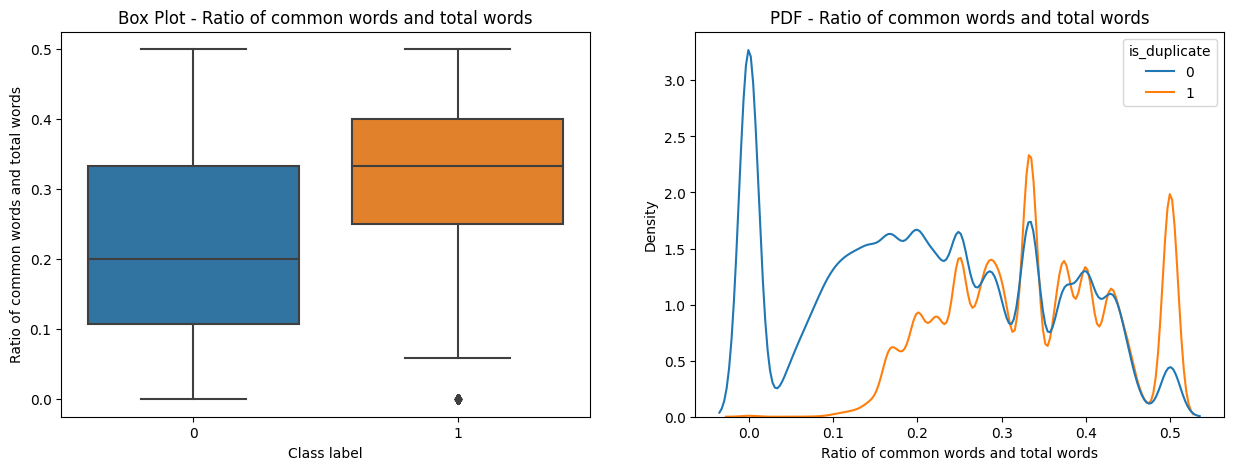

In [ ]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)

sns.boxplot(x='is_duplicate' , y='ratio_of_common_words_of_q1q2_and_total_words' , data=df)
plt.title('Box Plot - Ratio of common words and total words')
plt.xlabel('Class label')
plt.ylabel('Ratio of common words and total words')

plt.subplot(1,2,2)

sns.kdeplot(x='ratio_of_common_words_of_q1q2_and_total_words' , hue='is_duplicate' , data=df , shade=False)
plt.title('PDF - Ratio of common words and total words')
plt.xlabel('Ratio of common words and total words')

plt.show()

<ipython-input-42-e1323edbf420>:12: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=False`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(x='ratio_of_common_words_of_q1q2_and_total_unique_words' , hue='is_duplicate' , data=df , shade=False)


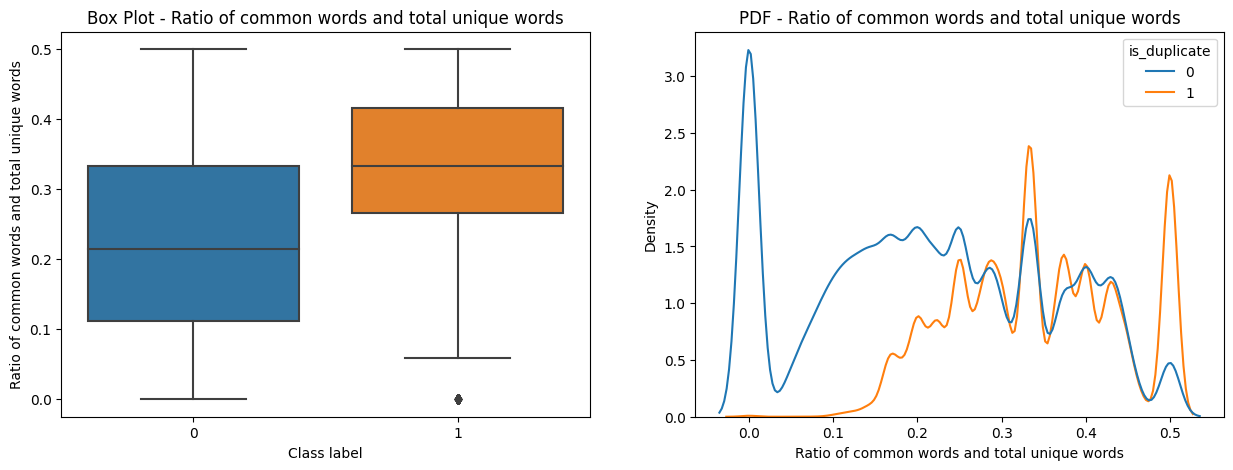

In [ ]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)

sns.boxplot(x='is_duplicate' , y='ratio_of_common_words_of_q1q2_and_total_unique_words' , data=df)
plt.title('Box Plot - Ratio of common words and total unique words')
plt.xlabel('Class label')
plt.ylabel('Ratio of common words and total unique words')

plt.subplot(1,2,2)

sns.kdeplot(x='ratio_of_common_words_of_q1q2_and_total_unique_words' , hue='is_duplicate' , data=df , shade=False)
plt.title('PDF - Ratio of common words and total unique words')
plt.xlabel('Ratio of common words and total unique words')

plt.show()

<ipython-input-43-9cb29541231c>:12: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=False`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(x='ratio_of_common_words_and_length_of_smaller_question' , hue='is_duplicate' , data=df , shade=False)


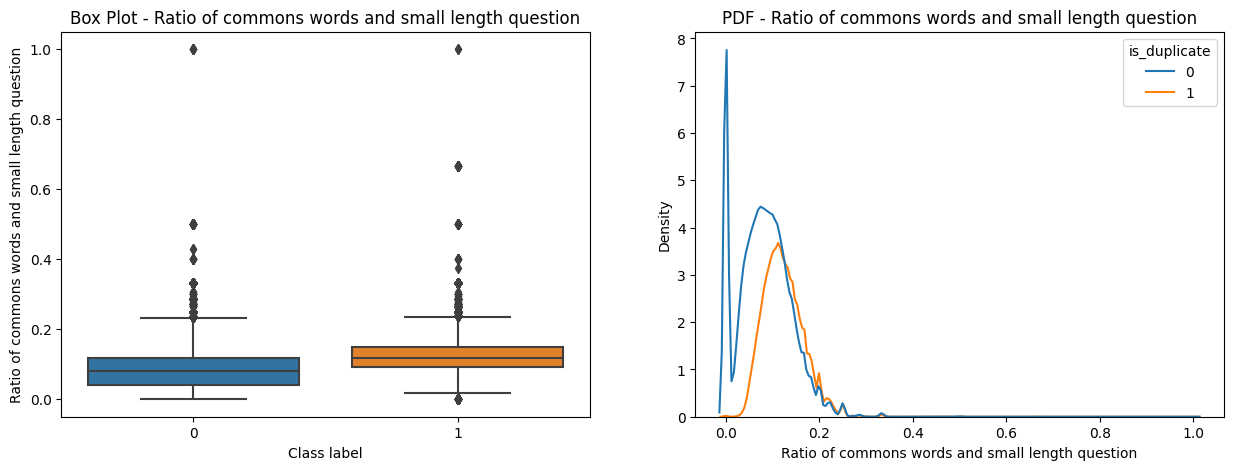

In [ ]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)

sns.boxplot(x='is_duplicate' , y='ratio_of_common_words_and_length_of_smaller_question' , data=df)
plt.title('Box Plot - Ratio of commons words and small length question')
plt.xlabel('Class label')
plt.ylabel('Ratio of commons words and small length question')

plt.subplot(1,2,2)

sns.kdeplot(x='ratio_of_common_words_and_length_of_smaller_question' , hue='is_duplicate' , data=df , shade=False)
plt.title('PDF - Ratio of commons words and small length question')
plt.xlabel('Ratio of commons words and small length question')

plt.show()

<ipython-input-44-c750c4e98195>:12: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=False`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(x='ratio_of_common_words_and_length_of_larger_question' , hue='is_duplicate' , data=df , shade=False)


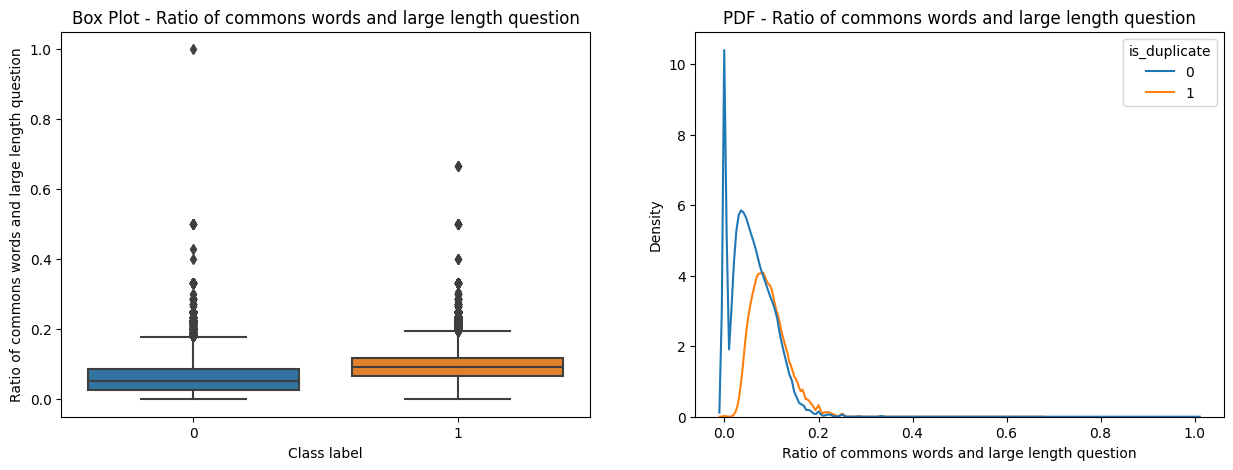

In [ ]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)

sns.boxplot(x='is_duplicate' , y='ratio_of_common_words_and_length_of_larger_question' , data=df)
plt.title('Box Plot - Ratio of commons words and large length question')
plt.xlabel('Class label')
plt.ylabel('Ratio of commons words and large length question')

plt.subplot(1,2,2)

sns.kdeplot(x='ratio_of_common_words_and_length_of_larger_question' , hue='is_duplicate' , data=df , shade=False)
plt.title('PDF - Ratio of commons words and large length question')
plt.xlabel('Ratio of commons words and large length question')

plt.show()

<ipython-input-45-849bb1559603>:12: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=False`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(x='fuzz_ratio' , hue='is_duplicate' , data=df , shade=False)


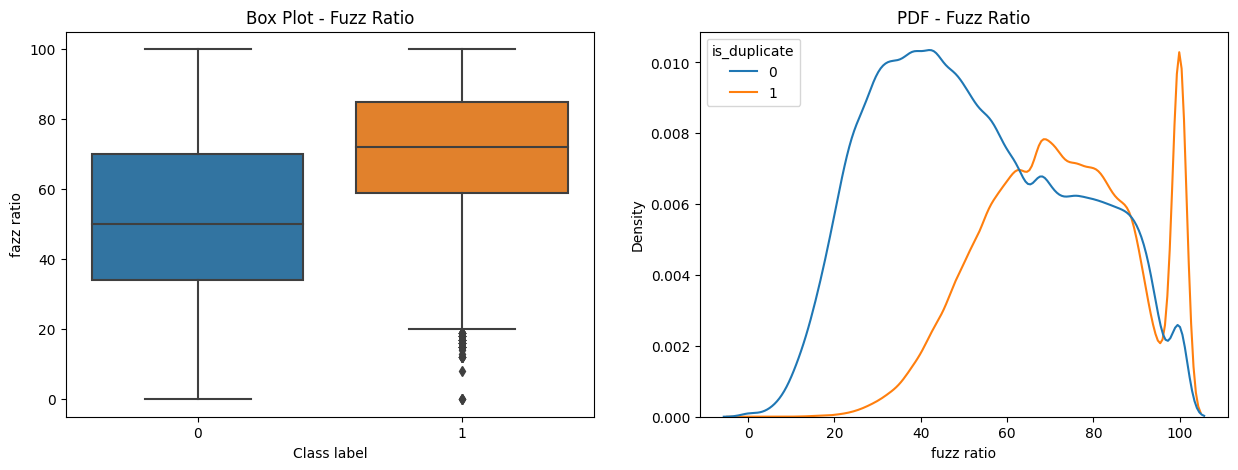

In [ ]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)

sns.boxplot(x='is_duplicate' , y='fuzz_ratio' , data=df)
plt.title('Box Plot - Fuzz Ratio')
plt.xlabel('Class label')
plt.ylabel('fazz ratio')

plt.subplot(1,2,2)

sns.kdeplot(x='fuzz_ratio' , hue='is_duplicate' , data=df , shade=False)
plt.title('PDF - Fuzz Ratio')
plt.xlabel('fuzz ratio')

plt.show()

<ipython-input-46-38757bec1af1>:12: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=False`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(x='fuzz_partial_ratio' , hue='is_duplicate' , data=df , shade=False)


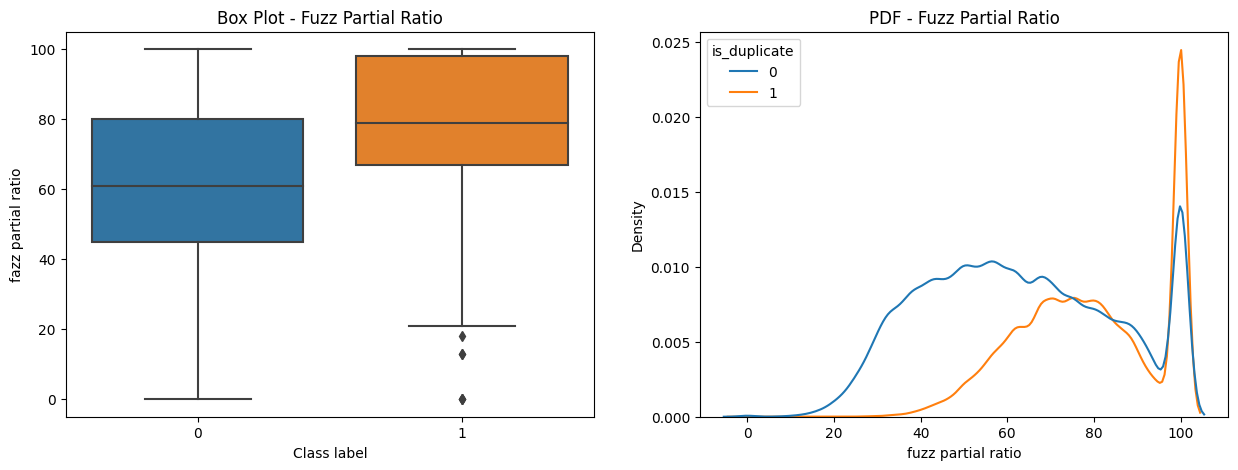

In [ ]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)

sns.boxplot(x='is_duplicate' , y='fuzz_partial_ratio' , data=df)
plt.title('Box Plot - Fuzz Partial Ratio')
plt.xlabel('Class label')
plt.ylabel('fazz partial ratio')

plt.subplot(1,2,2)

sns.kdeplot(x='fuzz_partial_ratio' , hue='is_duplicate' , data=df , shade=False)
plt.title('PDF - Fuzz Partial Ratio')
plt.xlabel('fuzz partial ratio')

plt.show()

<ipython-input-47-59534f65647e>:12: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=False`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(x='fuzz_token_sort_ratio' , hue='is_duplicate' , data=df , shade=False)


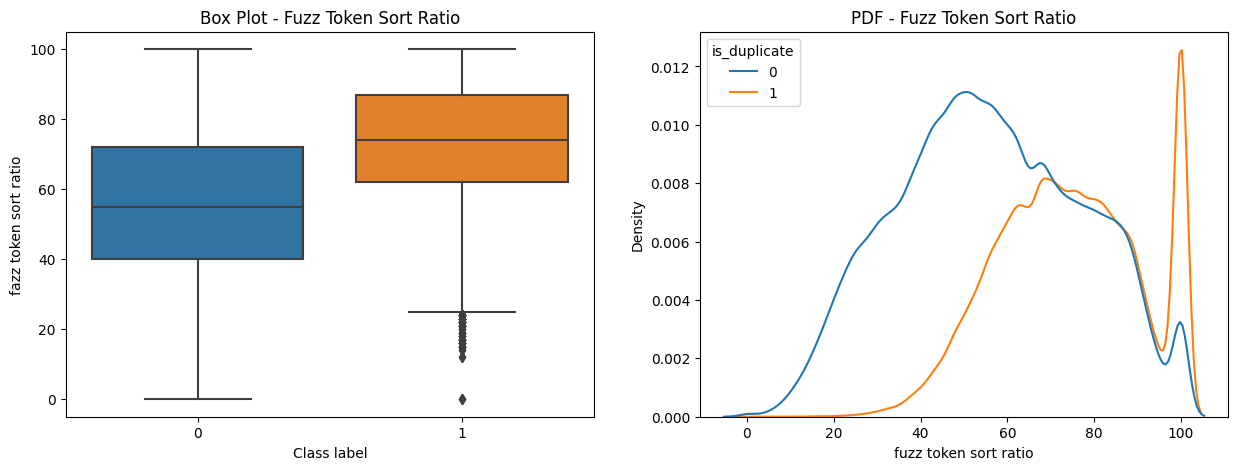

In [ ]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)

sns.boxplot(x='is_duplicate' , y='fuzz_token_sort_ratio' , data=df)
plt.title('Box Plot - Fuzz Token Sort Ratio')
plt.xlabel('Class label')
plt.ylabel('fazz token sort ratio')

plt.subplot(1,2,2)

sns.kdeplot(x='fuzz_token_sort_ratio' , hue='is_duplicate' , data=df , shade=False)
plt.title('PDF - Fuzz Token Sort Ratio')
plt.xlabel('fuzz token sort ratio')

plt.show()

<ipython-input-48-d79fb035fa91>:12: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=False`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(x='fuzz_token_set_ratio' , hue='is_duplicate' , data=df , shade=False)


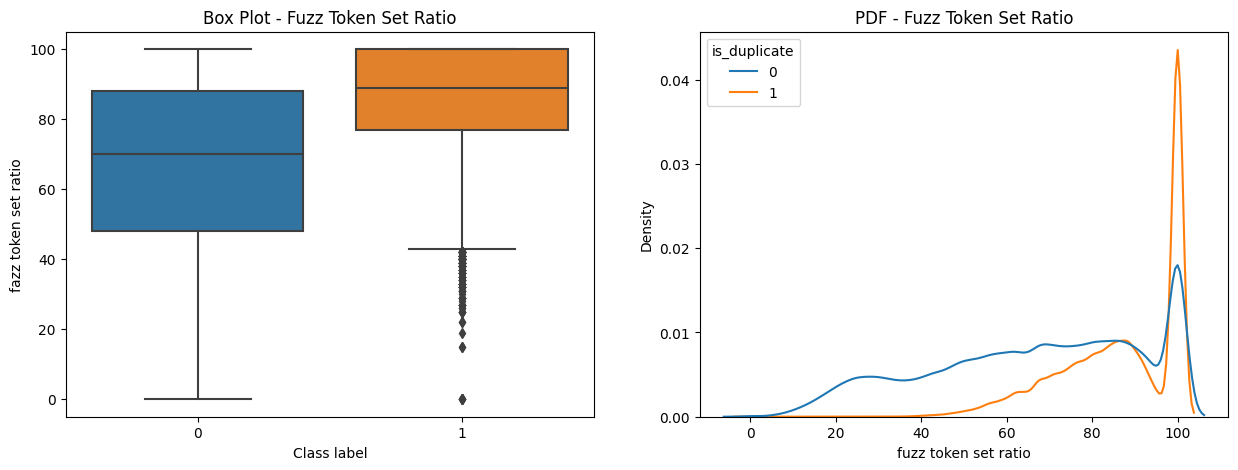

In [ ]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)

sns.boxplot(x='is_duplicate' , y='fuzz_token_set_ratio' , data=df)
plt.title('Box Plot - Fuzz Token Set Ratio')
plt.xlabel('Class label')
plt.ylabel('fazz token set ratio')

plt.subplot(1,2,2)

sns.kdeplot(x='fuzz_token_set_ratio' , hue='is_duplicate' , data=df , shade=False)
plt.title('PDF - Fuzz Token Set Ratio')
plt.xlabel('fuzz token set ratio')

plt.show()

### Due to same distribution droping some features

In [ ]:
#'ratio_of_common_words_of_q1q2_and_total_words' and 'ratio_of_common_words_of_q1q2_and_total_unique_words'
# features are giving same distribution so droping
# 'ratio_of_common_words_of_q1q2_and_total_unique_words' feature

df = df.drop('ratio_of_common_words_of_q1q2_and_total_unique_words' , axis=1)
df.shape


(404287, 23)

In [ ]:
# 'fuzz_ratio' and 'fuzz_token_sort_ratio'
# features are giving same distribution so droping 'fuzz_ratio'

df = df.drop('fuzz_ratio' , axis=1)
df.shape

(404287, 22)

In [ ]:
df['question1'] = df['question1'].apply(lambda text : str(text))
df['question2'] = df['question2'].apply(lambda text : str(text))

In [ ]:
df.shape

(404287, 22)

### Showing Worlcloud

In [ ]:
from wordcloud import WordCloud

In [ ]:
duplicate = df[df['is_duplicate']==1]
non_duplicate = df[df['is_duplicate']==0]

duplicate = np.array([duplicate['question1'] , duplicate['question2']]).flatten()
non_duplicate = np.array([non_duplicate['question1'], non_duplicate['question2']]).flatten()

dup_str = ' '.join(duplicate)
non_dup_str = ' '.join(non_duplicate)

stop_words = set(stopwords.words('english'))



Word cloud for duplicate pairs


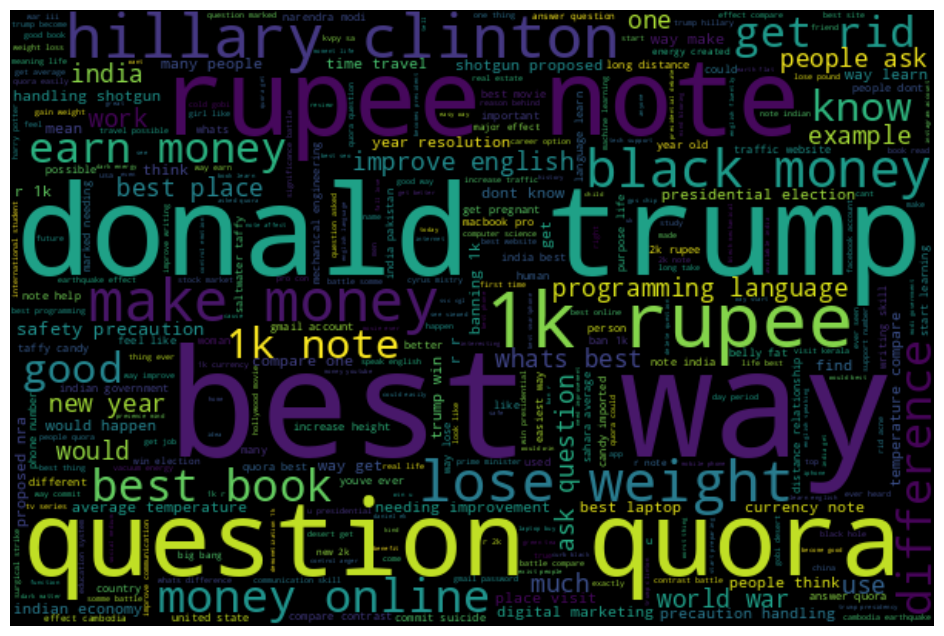

In [ ]:
word_cloud = WordCloud(background_color='black' , max_words=len(dup_str) , stopwords=stop_words , width=600 , height=400)
word_cloud.generate(dup_str)

print('Word cloud for duplicate pairs')
plt.figure(figsize=(15,8))
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')

plt.show()

Word cloud for non duplicate pairs


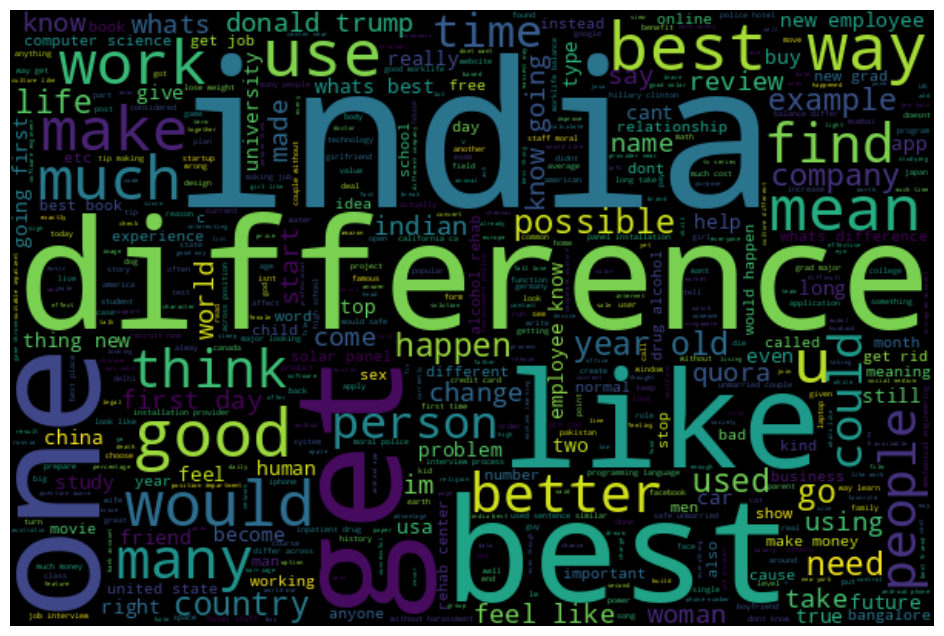

In [ ]:
word_cloud = WordCloud(background_color='black' , max_words=len(dup_str) , stopwords=stop_words , width=600 , height=400)
word_cloud.generate(non_dup_str)

print('Word cloud for non duplicate pairs')
plt.figure(figsize=(15,8))
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')

plt.show()

## Vectorization

In [ ]:
from numpy import vectorize
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm import tqdm
import spacy

In [ ]:
nlp = spacy.load('en_core_web_sm')

In [ ]:
# Merge texts
questions = list(data['question1'])+list(data['question2'])

tfidf = TfidfVectorizer(lowercase=False)
tfidf.fit_transform(questions)

#  dict key:word and value:tf-idf score
word2tfidf = dict(zip(tfidf.get_feature_names_out(), tfidf.idf_))

In [ ]:
vecs1 = []

for qu1 in tqdm(list(data['question1'])):
    doc1 = nlp(qu1)
    mean_vec1 = np.zeros([len(doc1), len(doc1[0].vector)])
    for word1 in doc1:
        # Word2Vec
        vec1 = word1.vector
        # Fetch df score
        try: idf = word2tfidf[str(word1)]
        except: idf = 0
        # Compute final vec
        mean_vec1 += vec1 * idf
    mean_vec1 = mean_vec1.mean(axis=0)
    vecs1.append(mean_vec1)
data['q1_feats_m'] = list(vecs1)


100%|██████████| 404287/404287 [53:43<00:00, 125.40it/s]
<ipython-input-62-a7aa64aaf5d4>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['q1_feats_m'] = list(vecs1)


In [ ]:
data.shape

(404287, 7)

In [ ]:
vecs2 = []
for qu2 in tqdm(list(data['question2'])):
    doc2 = nlp(qu2)
    mean_vec2 = np.zeros([len(doc1), len(doc2[0].vector)])
    for word2 in doc2:
        # Word2Vec
        vec2 = word2.vector
        # Fetch df score
        try: idf = word2tfidf[str(word2)]
        except: idf = 0ch
        # Compute final vec
        mean_vec2 += vec2 * idf
    mean_vec2 = mean_vec2.mean(axis=0)
    vecs2.append(mean_vec2)
data['q2_feats_m'] = list(vecs2)

100%|██████████| 404287/404287 [55:08<00:00, 122.21it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


In [ ]:
df10 = pd.DataFrame(vecs1)
df10.head()

,0,1,2,3,4,5,6,7,8,9,...,86,87,88,89,90,91,92,93,94,95
0,28.505129,-6.668537,27.934547,-35.303641,-13.590146,2.813860,-34.141779,-39.723842,13.908157,7.642739,...,21.425718,-1.578821,-26.098857,14.420263,-43.689753,-52.154592,39.668648,65.215793,3.648802,2.141562
1,80.920676,14.522501,8.747217,-10.627085,-32.863582,42.647853,-49.310829,-4.615761,24.387445,-10.313321,...,9.535697,-9.775646,-67.354410,7.883725,7.294846,-46.185453,-18.570699,47.658431,28.385373,26.411242
2,16.304053,10.466137,-16.121920,-2.034773,-12.671650,-3.325077,-4.964600,-40.802400,19.395455,0.458783,...,36.500548,14.436675,5.828367,36.516107,-31.183482,-33.911757,-0.510455,-18.043428,6.461976,-8.763222
3,25.437087,60.496332,-18.734628,-17.648509,10.607425,34.267043,-7.640623,-19.066536,36.765802,-18.292607,...,-17.919565,17.959593,-11.391141,6.164849,1.401953,10.194000,32.522184,-20.278078,36.932474,-12.494695
4,89.659855,-33.570989,32.713668,-32.018269,38.478440,14.766149,-15.869041,-72.610087,86.239417,-5.095634,...,-43.475522,1.631006,-22.070769,35.274329,34.909390,-44.466811,14.255962,29.884434,32.549350,49.327214


In [ ]:
data.shape

(404287, 8)

In [ ]:
df1 = df.drop(['qid1' , 'qid2' , 'question1' , 'question2'] , axis=1)
df2 = data.drop(['qid1' , 'qid2' , 'question1' , 'question2' , 'is_duplicate'], axis=1)

In [ ]:
print(df1.shape)
print(df2.shape)

(404287, 18)
(404287, 3)


In [ ]:
df2_q1 = pd.DataFrame(df2.q1_feats_m.values.tolist() , index = df2.index)
df2_q2 = pd.DataFrame(df2.q2_feats_m.values.tolist() , index = df2.index)

In [ ]:
print(df2_q1.shape)
print(df2_q2.shape)

(404287, 96)
(404287, 96)


In [ ]:
df2_q1['id'] = df1['id']
df2_q2['id'] = df1['id']

In [ ]:
df2 = df2_q1.merge(df2_q2 , on='id' , how='left')

In [ ]:
df2.shape

(404287, 193)

In [ ]:
result = df1.merge(df2 , on='id' , how='left')

In [ ]:
result.shape

(404287, 210)

In [ ]:
result.head()

,id,is_duplicate,length_of_q1,length_of_q2,total_number_of_words_in_q1,total_number_of_words_in_q2,sum_of_total_words_of_q1_and_q2,number_of_unique_words_in_q1,number_of_unique_words_in_q2,sum_of_total_uinque_words_of_q1_and_q2,...,86_y,87_y,88_y,89_y,90_y,91_y,92_y,93_y,94_y,95_y
0,0,0,41,35,7,6,13,6,5,11,...,28.148513,1.353421,-11.824830,11.047359,-46.344840,-48.177227,43.835738,34.804421,9.032392,-10.397807
1,1,0,31,67,4,9,13,3,8,11,...,9.847449,-6.033756,-41.089475,14.710464,-2.295947,-41.452743,-8.047282,32.255510,49.435528,7.736099
2,2,0,44,36,6,5,11,6,5,11,...,17.234969,-16.020370,11.371574,38.165736,-58.871103,-58.693385,25.354086,-8.443701,18.219825,4.179070
3,3,0,21,40,3,5,8,3,5,8,...,-0.328746,2.499022,13.687261,14.945715,-38.077479,-27.151390,-10.715000,-11.844023,7.744019,-38.738735
4,4,0,60,29,10,5,15,10,5,15,...,9.265299,6.862858,-24.873190,18.215849,-8.750949,-22.902608,24.033316,-9.201655,23.656173,0.068462


In [ ]:
result.isnull().sum().sum()

181

In [ ]:
result = result.dropna()

In [ ]:
result.shape

(404166, 210)

## Data splitting

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
import xgboost as xgb
!pip install catboost
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from catboost import CatBoostClassifier
import catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 989 kB/s 


In [ ]:
result = result.drop('id' , axis=1)

In [ ]:
X = result.drop('is_duplicate' , axis=1)
Y = result['is_duplicate']

In [ ]:
print(X.shape , Y.shape)

(404166, 208) (404166,)


In [ ]:
x_train , x_test , y_train , y_test = train_test_split(X , Y , test_size=0.4 , random_state=1)

In [ ]:
print(x_train.shape , x_test.shape , y_train.shape , y_test.shape)

(242499, 208) (161667, 208) (242499,) (161667,)


## Error Analysis

In [ ]:
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    log_loss,
    precision_score,
    recall_score,
    f1_score,
)
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:

class EvaluateModel:
    def __init__(self, x_test, y_test, model):
        self.x_test = x_test
        self.y_test = y_test
        self.model = model

    def evaluate_model(self):
        print("Evaluating the model:- ")
        y_pred = self.model.predict(self.x_test)
        print("Accuracy Score:- ", accuracy_score(self.y_test, y_pred))
        print("Precision Score:- ", precision_score(self.y_test, y_pred))
        print("Recall Score:- ", recall_score(self.y_test, y_pred))
        print("F1 Score:- ", f1_score(self.y_test, y_pred))
        print(
            "Log Loss:- ", log_loss(self.y_test, self.model.predict_proba(self.x_test))
        )
        print("Completed evaluating the model")

    def plot_confusion_matrix(self, test_y, predict_y):
        confusion = confusion_matrix(test_y, predict_y)

        Recall = ((confusion.T) / (confusion.sum(axis=1))).T
        # divide each element of the confusion matrix with the sum of elements in that column

        Precision = confusion / confusion.sum(axis=0)
        # divide each element of the confusion matrix with the sum of elements in that row

        plt.figure(figsize=(20, 4))

        labels = [0, 1]
        cmap = sns.light_palette("blue")
        plt.subplot(1, 3, 1)
        sns.heatmap(
            confusion,
            annot=True,
            cmap=cmap,
            fmt=".3f",
            xticklabels=labels,
            yticklabels=labels,
        )
        plt.xlabel("Predicted Class")
        plt.ylabel("Original Class")
        plt.title("Confusion matrix")

        plt.subplot(1, 3, 2)
        sns.heatmap(
            Precision,
            annot=True,
            cmap=cmap,
            fmt=".3f",
            xticklabels=labels,
            yticklabels=labels,
        )
        plt.xlabel("Predicted Class")
        plt.ylabel("Original Class")
        plt.title("Precision matrix")

        plt.subplot(1, 3, 3)
        sns.heatmap(
            Recall,
            annot=True,
            cmap=cmap,
            fmt=".3f",
            xticklabels=labels,
            yticklabels=labels,
        )
        plt.xlabel("Predicted Class")
        plt.ylabel("Original Class")
        plt.title("Recall matrix")

        plt.show()

    def plot_roc_curve(self, test_y, predict_y):
        auroc = roc_auc_score(test_y, predict_y)
        print("AUROC Score:- ", auroc)
        fpr, tpr, _ = roc_curve(test_y, predict_y)
        plt.plot(
            fpr, tpr, linestyle="--", label="Prediction_for_lr (AUROC = %0.3f)" % auroc
        )
        plt.title("ROC Plot")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.legend()
        plt.show()

## SVM Model

In [ ]:
def svm_model(x_train , y_train , fine_tuning=True):
    if fine_tuning:
        print("Started Finetuning the model:- ")
        C = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
        gamma = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
        params = {
            "C": C,
            "gamma": gamma,
        }
        svm = SVC()
        clf = RandomizedSearchCV(svm, params, cv=5, n_jobs=-1)
        clf.fit(x_train,y_train)
        print("Finished Hyperparameter search")
        return clf
    else:
        print("Started training the model:- ")
        svm = SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
            decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
            max_iter=-1, probability=True, random_state=None, shrinking=True,
            tol=0.001, verbose=False)
        svm.fit(x_train, y_train)
        print("Completed training the model")
        return svm
svm = svm_model(x_train , y_train , fine_tuning=False)
svm_predict = svm.predict(x_test)
evaluate_svm = EvaluateModel(x_test , y_test , svm)
evaluate_svm.evaluate_model()
evaluate_svm.plot_confusion_matrix(y_test , svm_predict)
evaluate_svm.plot_roc_curve(y_test , svm_predict)

Started training the model:- 


## Logistic Regression

In [ ]:
def logistic_regression_model(x_train , y_train):
    print("Training the model logistic regression model:- ")
    log_reg = LogisticRegression(max_iter=10000)
    log_reg.fit(x_train, y_train)

    print("Completed training the model")
    return log_reg
lr = logistic_regression_model(x_train , y_train)
lr_predict = lr.predict(x_test)
evaluate_lr = EvaluateModel(x_test , y_test , lr)
evaluate_lr.evaluate_model()
evaluate_lr.plot_confusion_matrix(y_test , lr_predict)
evaluate_lr.plot_roc_curve(y_test , lr_predict)

## Naive Bayes

In [ ]:
def naive_bayes((x_train , y_train):
  print("Training the model naive bayes model:- ")
  model = GaussianNB(var_smoothing=7.127035668355718)
  model.fit((x_train , y_train)
  print("Completed training the model")
  return model
nb = naive_bayes(x_train , y_train)
nb_predict = nb.predict(x_test)
evaluate_nb = EvaluateModel(x_test , y_test , nb)
evaluate_nb.evaluate_model()
evaluate_nb.plot_confusion_matrix(y_test , nb_predict)
evaluate_nb.plot_roc_curve(y_test , nb_predict)

## Decision Tree

In [ ]:
def decision_trees(x_train , y_train):
  print("Training the model Decision Trees model")
  model = DecisionTreeClassifier(
      criterion="entropy", max_depth=1, min_samples_split=7
    )
  model.fit(x_train , y_train)
   print("Completed training the model")
  return model
dt = decision_trees(x_train , y_train)
dt_predict = dt.predict(x_test)
evaluate_dt = EvaluateModel(x_test , y_test , dt)
evaluate_dt.evaluate_model()
evaluate_dt.plot_confusion_matrix(y_test , dt_predict)
evaluate_dt.plot_roc_curve(y_test , dt_predict)

## Random Forest

In [ ]:
def random_forest((x_train , y_train):
  print("Training the model Random Forest model")
  model = RandomForestClassifier(
      n_estimators=92, max_depth=19, min_samples_split=4
      )
  model.fit((x_train , y_train)
  print("Completed training the model")
  return model
rf = random_forest(x_train , y_train)
rf_predict = rf.predict(x_test)
evaluate_rf = EvaluateModel(x_test , y_test , rf)
evaluate_rf.evaluate_model()
evaluate_rf.plot_confusion_matrix(y_test , rf_predict)
evaluate_rf.plot_roc_curve(y_test , rf_predict)

## Adaboost

In [ ]:
def adaboost((x_train , y_train):
  print("Training the model AdaBoost model")
  model = AdaBoostClassifier(
      n_estimators=143, learning_rate=0.2374269674908056
      )
  model.fit((x_train , y_train)
  print("Completed training the model")
  return model
ad = adaboost(x_train , y_train)
ad_predict = ad.predict(x_test)
evaluate_ad = EvaluateModel(x_test , y_test , ad)
evaluate_ad.evaluate_model()
evaluate_ad.plot_confusion_matrix(y_test , ad_predict)
evaluate_ad.plot_roc_curve(y_test , ad_predict)

## XGBoost

In [ ]:
def Xgboost_model((x_train , y_train):
  print("Started training the XgBoost model:- ")
  xgb = XGBClassifier(
      learning_rate=0.3,
      max_delta_step=0,
      max_depth=8,
      min_child_weight=1,
      n_estimators=50,
      n_jobs=16,
      num_parallel_tree=1,
      random_state=0,
      reg_alpha=0,
      reg_lambda=1,
      scale_pos_weight=1,
      subsample=1.0,
      tree_method="exact",
      validate_parameters=1,
      verbosity=None,
    )
  xgb.fit((x_train , y_train)
  print("Completed training the XgBoost model")
  joblib.dump(xgb , "xgb.pkl")
  return xgb
xgb = Xgboost_model(x_train , y_train)
xgb_predict = xgb.predict(x_test)
evaluate_xgb = EvaluateModel(x_test , y_test , xgb)
evaluate_xgb.evaluate_model()
evaluate_xgb.plot_confusion_matrix(y_test , xgb_predict)
evaluate_xgb.plot_roc_curve(y_test , xgb_predict)

## CatBoost

In [ ]:
def catboost((x_train , y_train):
  print("Entered for training CatBoost model")
  clf = CatBoostClassifier(
      loss_function="Logloss",
      l2_leaf_reg=0.005603859124543057,
      max_bin=332,
      learning_rate=0.0075037108414941255,
      n_estimators=1297,
      max_depth=16,
      random_state=24,
      min_data_in_leaf=94,
  )
  clf.fit((x_train , y_train)
  print("Completed training the model")
  return clf
cb = Xgboost_model(x_train , y_train)
cb_predict = cb.predict(x_test)
evaluate_cb = EvaluateModel(x_test , y_test , cb)
evaluate_cb.evaluate_model()
evaluate_cb.plot_confusion_matrix(y_test , cb_predict)
evaluate_cb.plot_roc_curve(y_test , cb_predict)

## LSTM

### Create embedding matrix

In [ ]:
vocabulary = dict()
inverse_vocabulary = ['<unk>']  # '<unk>' will never be used, it is only a placeholder for the [0, 0, ....0] embedding
word2vec = KeyedVectors.load_word2vec_format(EMBEDDING_FILE, binary=True)

In [ ]:
questions_cols = ['question1', 'question2']
stops = set(stopwords.words('english'))

# Iterate over the questions only of both training and test datasets
for dataset in [train_df]:
    for index, row in dataset.iterrows():

        # Iterate through the text of both questions of the row
        for question in questions_cols:

            q2n = []  # q2n -> question numbers representation
            for word in row[question]:

                # Check for unwanted words
                if word in stops and word not in word2vec.vocab:
                    continue

                if word not in vocabulary:
                    vocabulary[word] = len(inverse_vocabulary)
                    q2n.append(len(inverse_vocabulary))
                    inverse_vocabulary.append(word)
                else:
                    q2n.append(vocabulary[word])

            # Replace questions as word to question as number representation
            dataset.at[index, question] = q2n

embedding_dim = 300
embeddings = 1 * np.random.randn(len(vocabulary) + 1, embedding_dim)  # This will be the embedding matrix
embeddings[0] = 0  # So that the padding will be ignored

# Build the embedding matrix
for word, index in vocabulary.items():
    if word in word2vec.vocab:
        embeddings[index] = word2vec.word_vec(word)

del word2vec

##Prepare training and validation data

In [ ]:
max_seq_length = max(train_df.question1.map(lambda x: len(x)).max(),
                     train_df.question2.map(lambda x: len(x)).max())

# Split to train validation
validation_size = 4000
training_size = len(train_df) - validation_size

X = train_df[questions_cols]
Y = train_df['is_duplicate']

X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=validation_size)

# Split to dicts
X_train = {'left': X_train.question1, 'right': X_train.question2}
X_validation = {'left': X_validation.question1, 'right': X_validation.question2}

# Convert labels to their numpy representations
Y_train = Y_train.values
Y_validation = Y_validation.values

# Zero padding
for dataset, side in itertools.product([X_train, X_validation], ['left', 'right']):
    dataset[side] = pad_sequences(dataset[side], maxlen=max_seq_length)

# Make sure everything is ok
assert X_train['left'].shape == X_train['right'].shape
assert len(X_train['left']) == len(Y_train)

## Build the model

In [ ]:
# Model variables
n_hidden = 50
gradient_clipping_norm = 1.25
batch_size = 64
n_epoch = 25

def exponent_neg_manhattan_distance(left, right):
    ''' Helper function for the similarity estimate of the LSTMs outputs'''
    return K.exp(-K.sum(K.abs(left-right), axis=1, keepdims=True))

# The visible layer
left_input = Input(shape=(max_seq_length,), dtype='int32')
right_input = Input(shape=(max_seq_length,), dtype='int32')

embedding_layer = Embedding(len(embeddings), embedding_dim, weights=[embeddings], input_length=max_seq_length, trainable=False)

# Embedded version of the inputs
encoded_left = embedding_layer(left_input)
encoded_right = embedding_layer(right_input)

# Since this is a siamese network, both sides share the same LSTM
shared_lstm = LSTM(n_hidden)

left_output = shared_lstm(encoded_left)
right_output = shared_lstm(encoded_right)

# Calculates the distance as defined by the MaLSTM model
malstm_distance = Lambda(function=lambda x: exponent_neg_manhattan_distance(x[0], x[1]),output_shape=lambda x: (x[0][0], 1))([left_output, right_output])

# Pack it all up into a model
malstm = Model([left_input, right_input], [malstm_distance])

# Adadelta optimizer, with gradient clipping by norm
optimizer = Adadelta(clipnorm=gradient_clipping_norm)

malstm.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['accuracy'])

# Start training
training_start_time = time()

malstm_trained = malstm.fit([X_train['left'], X_train['right']], Y_train, batch_size=batch_size, epochs=n_epoch,
                            validation_data=([X_validation['left'], X_validation['right']], Y_validation))

print("Training time finished.\n{} epochs in {}".format(n_epoch, datetime.timedelta(seconds=time()-training_start_time)))

##Plotting the results

In [ ]:
# Plot accuracy
plt.plot(malstm_trained.history['accuracy'])
plt.plot(malstm_trained.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot loss
plt.plot(malstm_trained.history['loss'])
plt.plot(malstm_trained.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [ ]:
!pip install semantic-text-similarity
import pandas as pd
import numpy as np

In [ ]:
from semantic_text_similarity.models import ClinicalBertSimilarity
from scipy.stats import pearsonr

model = ClinicalBertSimilarity()
predictions = model.predict([("The patient is sick.", "Grass is green."),
                             ("A prescription of acetaminophen 325 mg was given."," The patient was given Tylenol.")])

print(predictions)

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/Kirti1807/Quora-Question-Similarity-Pair/main/train.csv')
df.head()

In [ ]:
df = df.dropna()

In [ ]:
df = df.drop(['id', 'qid1','qid2','is_duplicate'], axis=1)


In [ ]:
df['col'] = list(zip(df.question1, df.question2))
df = df.drop(['question1', 'question2'], axis=1)

In [ ]:
df = df['col'].tolist()

In [ ]:
predictions = model.predict(df)

print(predictions)

[3.7964373  3.2474678  3.139395   ... 4.2450933  0.03636459 4.759266  ]


In [ ]:
df2 = pd.DataFrame({'col':df})
df2["result"] = predictions
df2

,col,result
0,(What is the step by step guide to invest in s...,3.796437
1,(What is the story of Kohinoor (Koh-i-Noor) Di...,3.247468
2,(How can I increase the speed of my internet c...,3.139395
3,(Why am I mentally very lonely? How can I solv...,0.252246
4,"(Which one dissolve in water quikly sugar, sal...",2.045867
...,...,...
404282,(How many keywords are there in the Racket pro...,3.519988
404283,"(Do you believe there is life after death?, Is...",4.704713
404284,"(What is one coin?, What's this coin?)",4.245093
404285,(What is the approx annual cost of living whil...,0.036365


In [ ]:
df3 = pd.read_csv('https://raw.githubusercontent.com/Kirti1807/Quora-Question-Similarity-Pair/main/data/train.csv')
df2["is_duplicate"] = df3["is_duplicate"]
df2

,col,result,is_duplicate
0,(What is the step by step guide to invest in s...,3.796437,0
1,(What is the story of Kohinoor (Koh-i-Noor) Di...,3.247468,0
2,(How can I increase the speed of my internet c...,3.139395,0
3,(Why am I mentally very lonely? How can I solv...,0.252246,0
4,"(Which one dissolve in water quikly sugar, sal...",2.045867,0
...,...,...,...
404282,(How many keywords are there in the Racket pro...,3.519988,1
404283,"(Do you believe there is life after death?, Is...",4.704713,0
404284,"(What is one coin?, What's this coin?)",4.245093,1
404285,(What is the approx annual cost of living whil...,0.036365,0


In [ ]:
import seaborn as sns

In [ ]:
df2.to_csv("file.csv")

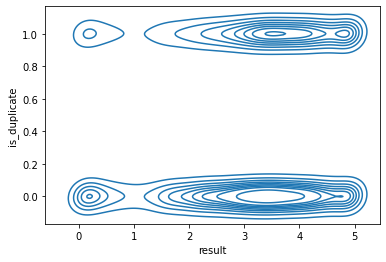

In [ ]:
sns.kdeplot(x='result' , y ='is_duplicate' , data=df2)

In [ ]:
pip install sentence-transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 85 kB 4.9 MB/s 
     |████████████████████████████████| 5.5 MB 32.5 MB/s 
     |████████████████████████████████| 182 kB 68.4 MB/s 
     |████████████████████████████████| 7.6 MB 49.6 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125938 sha256=2462186236cfe1f5fa255611911a683f4a72065c91b59dbf2e3eca87f3132195
  Stored in directory: /root/.cache/pip/wheels/bf/06/fb/d59c1e5bd1dac7f6cf61ec0036cc3a10ab8fecaa6b2c3d3ee9
Successfully built sentence-transformers


In [ ]:
from sentence_transformers import CrossEncoder
model = CrossEncoder('cross-encoder/nli-roberta-base')
scores = model.predict(df)

#Convert scores to labels
label_mapping = ['contradiction', 'entailment', 'neutral']
labels = [label_mapping[score_max] for score_max in scores.argmax(axis=1)]

Downloading:   0%|          | 0.00/702 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/499M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/772 [00:00<?, ?B/s]

In [ ]:
print(labels)

['entailment', 'neutral', 'contradiction', 'contradiction', 'neutral', 'contradiction', 'contradiction', 'neutral', 'neutral', 'contradiction', 'contradiction', 'contradiction', 'neutral', 'contradiction', 'neutral', 'contradiction', 'contradiction', 'neutral', 'entailment', 'entailment', 'neutral', 'contradiction', 'entailment', 'neutral', 'contradiction', 'contradiction', 'contradiction', 'neutral', 'entailment', 'contradiction', 'contradiction', 'contradiction', 'entailment', 'contradiction', 'neutral', 'contradiction', 'contradiction', 'neutral', 'neutral', 'entailment', 'neutral', 'neutral', 'neutral', 'neutral', 'contradiction', 'entailment', 'contradiction', 'neutral', 'neutral', 'entailment', 'neutral', 'neutral', 'contradiction', 'neutral', 'contradiction', 'neutral', 'entailment', 'contradiction', 'neutral', 'neutral', 'neutral', 'neutral', 'contradiction', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'contradiction', 'contradiction', 'neutral', 'contradi

In [ ]:
df2 = pd.DataFrame({'col':df})
df2["result"] = labels
df2

,col,result
0,(What is the step by step guide to invest in s...,entailment
1,(What is the story of Kohinoor (Koh-i-Noor) Di...,neutral
2,(How can I increase the speed of my internet c...,contradiction
3,(Why am I mentally very lonely? How can I solv...,contradiction
4,"(Which one dissolve in water quikly sugar, sal...",neutral
...,...,...
9995,(What would happen to the sun if liquid iron i...,entailment
9996,(Are the answers provided by Quora users genui...,entailment
9997,(How do you reinstall the Apple app store on a...,neutral
9998,(How should I work my way up to get selected f...,entailment


In [ ]:
df3 = df2
print(scores)

[[-1.7620169   2.4352639  -0.9795325 ]
 [ 1.9023122  -3.3387349   2.6232967 ]
 [ 2.7161605  -2.2592003   0.28726873]
 ...
 [-1.7189368  -0.13102974  2.6106002 ]
 [-2.48477     2.3796535  -0.16712351]
 [-3.875248    0.44044268  3.5202806 ]]


In [ ]:
df3 = pd.read_csv('https://raw.githubusercontent.com/Kirti1807/Quora-Question-Similarity-Pair/main/data/train.csv')
df2["is_duplicate"] = df3["is_duplicate"]
df2

,col,result,is_duplicate
0,(What is the step by step guide to invest in s...,entailment,0
1,(What is the story of Kohinoor (Koh-i-Noor) Di...,neutral,0
2,(How can I increase the speed of my internet c...,contradiction,0
3,(Why am I mentally very lonely? How can I solv...,contradiction,0
4,"(Which one dissolve in water quikly sugar, sal...",neutral,0
...,...,...,...
9995,(What would happen to the sun if liquid iron i...,entailment,0
9996,(Are the answers provided by Quora users genui...,entailment,0
9997,(How do you reinstall the Apple app store on a...,neutral,0
9998,(How should I work my way up to get selected f...,entailment,1
